# UKKO - Transformer model for tabular longitudonal data 

Author: Eric Fey (eric.fey@hus.fi)
First version: 2025-03-01

Usage:
1. Install hatchling 
  ```bash
  pip install hatchling
  ```
2. Install ukko package in development (editable) mode:
  ```bash
  pip install -e .
  ```
3. Go :smiley:

In [4]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///users/ericfey1/github/ukko
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... one
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ukko (pyproject.toml) ... done
  Created wheel for ukko: filename=ukko-0.1.0-py3-none-any.whl size=1088 sha256=ecf792c0a5f0ba587d1f251fb19a246789501725ec70f3b0c387eb4910a892fa
  Stored in directory: /tmp/ericfey1/26990614/pip-ephem-wheel-cache-im54xr4s/wheels/d6/05/1b/87b6398b4c9fcb6c3490d41e36b033368cd35528f738f0e67e
Successfully built ukko
  Attempting uninstall: ukko
    Found existing installation: ukko 0.1.0
    Uninstalling ukko-0.1.0:
      Successfully uninstalled ukko-0.1.0

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --

In [4]:
# attention model with residual connection
import torch
import torch.nn as nn
import math
import ukko 
import importlib

In [5]:
# Test ukko installatin and model
importlib.reload(ukko.core)
%run ./tests/tests_core.py
test_model();

Input shape: torch.Size([2, 3, 5])
Output shape: torch.Size([2, 3])
Feature attention weights shape: torch.Size([10, 5, 3, 3])
Time attention weights shape: torch.Size([6, 5, 5, 5])


### Uninstall re-install

In case there is trouble

In [9]:
!pip uninstall --yes ukko 

Found existing installation: ukko 0.1.0
Uninstalling ukko-0.1.0:
  Successfully uninstalled ukko-0.1.0


In [10]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///users/ericfey1/github/ukko
  Installing build dependencies ... one
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... one
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ukko (pyproject.toml) ... done
  Created wheel for ukko: filename=ukko-0.1.0-py3-none-any.whl size=1088 sha256=ecf792c0a5f0ba587d1f251fb19a246789501725ec70f3b0c387eb4910a892fa
  Stored in directory: /tmp/ericfey1/26990614/pip-ephem-wheel-cache-zn7o1jjp/wheels/d6/05/1b/87b6398b4c9fcb6c3490d41e36b033368cd35528f738f0e67e
Successfully built ukko

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


# Test data: sine wave

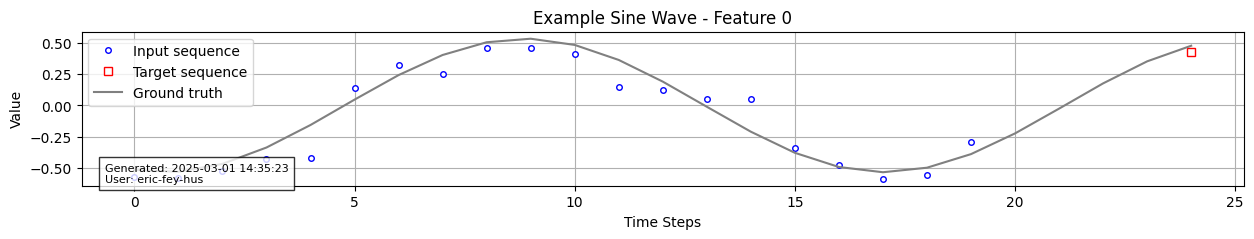

In [6]:
import numpy as np
import ukko 
from ukko.data import SineWaveDataset
import importlib
importlib.reload(ukko.data)
importlib.reload(ukko.core)

batch_size = 32
n_samples = 10
n_features = 3
sequence_length = 20
prediction_length = 5

mydataset = ukko.data.SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
ukko.data.plot_example_dataset(mydataset, sample_idx=0, feature_idx=0)


In [28]:
type(mydataset.data)
mydataset.data.shape

torch.Size([10, 3, 25])

In [93]:
phase_array = np.random.uniform(0, 2 * np.pi, n_features)
phase_array[0]

0.12933619211510794

# Test model using sinewave data

## Generate test dataset

[0.53087674 1.95486478 1.74866396 0.81850867 0.77273745]
[0.53087674 1.95486478 1.74866396 0.81850867 0.77273745]


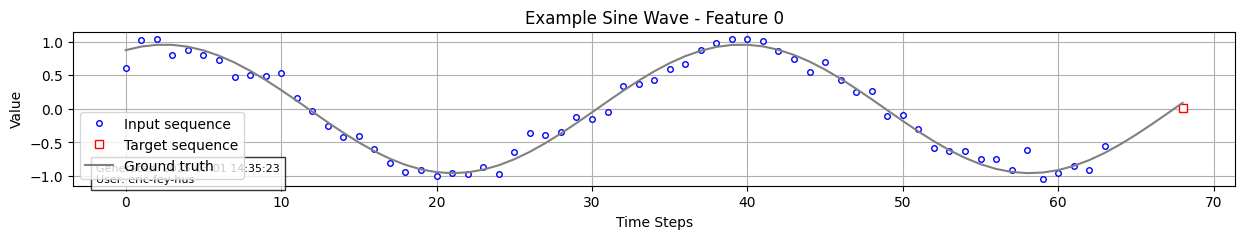

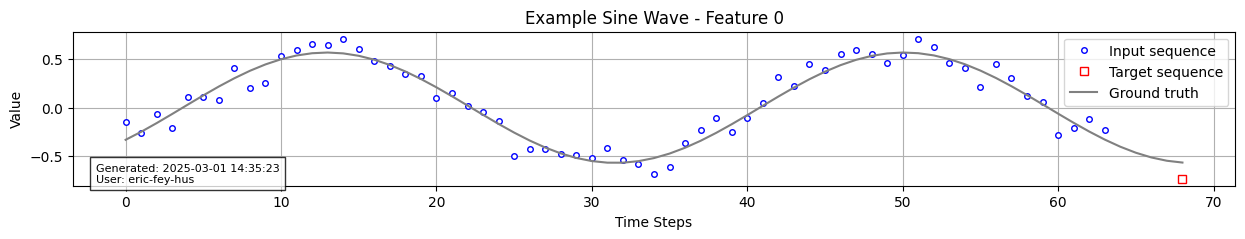

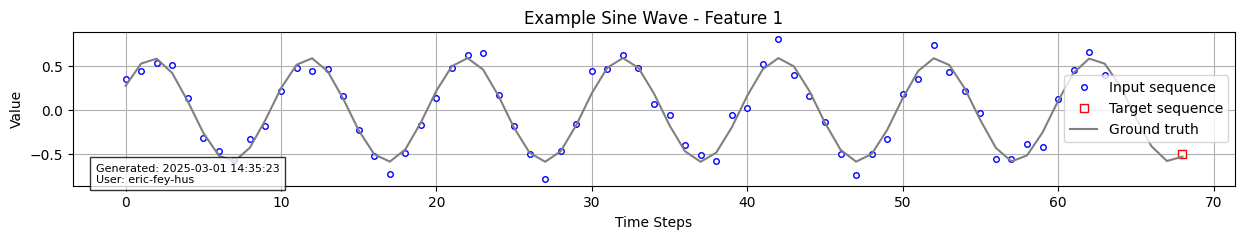

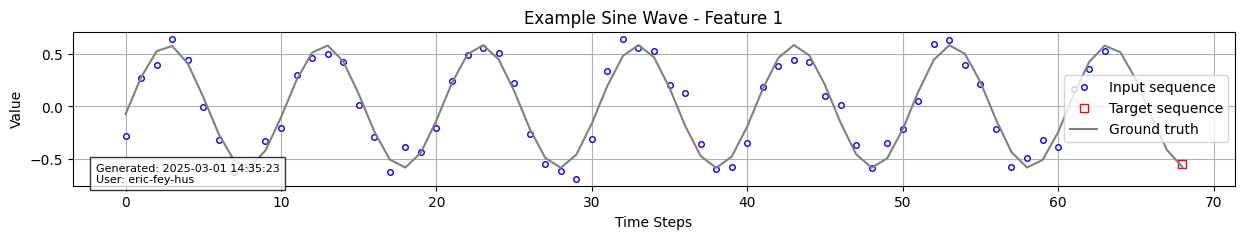

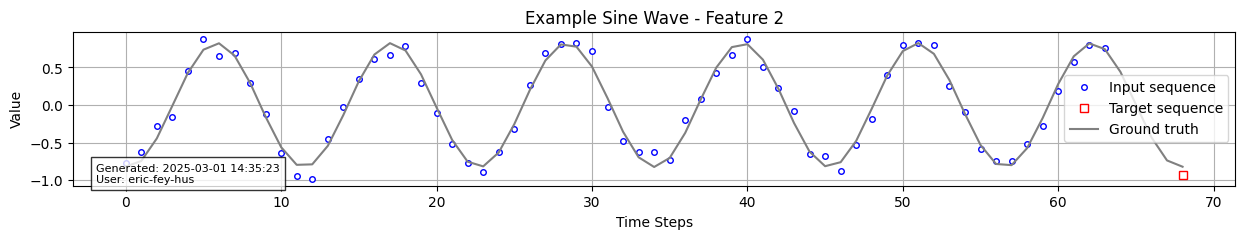

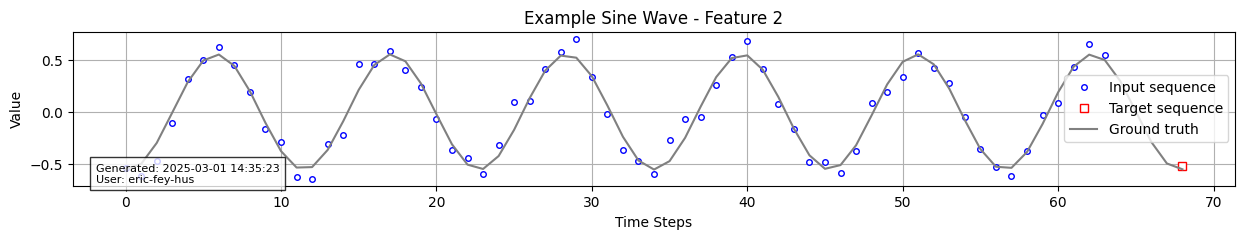

In [48]:
# Test model using sine data

import torch, ukko, importlib
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datetime import datetime

importlib.reload(ukko.data)
importlib.reload(ukko.core)
importlib.reload(ukko.test)

# Parameters
batch_size = 32
n_samples = 1000
n_features = 5
sequence_length = 64
prediction_length = 5

# Create datasets
#train_dataset = ukko.data.SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
#val_dataset = ukko.data.SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=43)
#test_dataset = ukko.data.SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=44)
train_dataset, val_dataset, test_dataset = ukko.test.create_datasets(
    n_samples = n_samples, 
    n_features = n_features, 
    sequence_length = sequence_length, 
    prediction_length = 5,
    base_freq=0.05,
)
print(train_dataset.freq_array)
print(val_dataset.freq_array)

# Create data loaders
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size)
#test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_loader, val_loader, test_loader = ukko.test.create_dataloaders(
    datasets=(train_dataset, val_dataset, test_dataset), 
    batch_size=batch_size
)

# Plot example
ukko.data.plot_example_dataset(train_dataset, sample_idx=0)
ukko.data.plot_example_dataset(train_dataset, sample_idx=1)
ukko.data.plot_example_dataset(train_dataset, feature_idx=1, sample_idx=0)
ukko.data.plot_example_dataset(train_dataset, feature_idx=1, sample_idx=1)
ukko.data.plot_example_dataset(train_dataset, feature_idx=2, sample_idx=3)
ukko.data.plot_example_dataset(train_dataset, feature_idx=2, sample_idx=4)


## Initialize and train model



Epoch   1/20, Train Loss: 1.8009, Val Loss: 0.8843
Epoch   2/20, Train Loss: 0.8488, Val Loss: 0.6651
Epoch   3/20, Train Loss: 0.3740, Val Loss: 0.3506
Epoch   4/20, Train Loss: 0.2025, Val Loss: 0.1203
Epoch   5/20, Train Loss: 0.1334, Val Loss: 0.1259
Epoch   6/20, Train Loss: 0.1211, Val Loss: 0.0729
Epoch   7/20, Train Loss: 0.1108, Val Loss: 0.1178
Epoch   8/20, Train Loss: 0.0983, Val Loss: 0.0806
Epoch   9/20, Train Loss: 0.1015, Val Loss: 0.0782
Epoch  10/20, Train Loss: 0.0871, Val Loss: 0.0599
Epoch  11/20, Train Loss: 0.0776, Val Loss: 0.1677
Epoch  12/20, Train Loss: 0.0928, Val Loss: 0.0669
Epoch  13/20, Train Loss: 0.0647, Val Loss: 0.0450
Epoch  14/20, Train Loss: 0.0941, Val Loss: 0.0554
Epoch  15/20, Train Loss: 0.0740, Val Loss: 0.0457
Epoch  16/20, Train Loss: 0.0463, Val Loss: 0.0364
Epoch  17/20, Train Loss: 0.0431, Val Loss: 0.0386
Epoch  18/20, Train Loss: 0.0452, Val Loss: 0.0341
Epoch  19/20, Train Loss: 0.0453, Val Loss: 0.0359
Epoch  20/20, Train Loss: 0.037

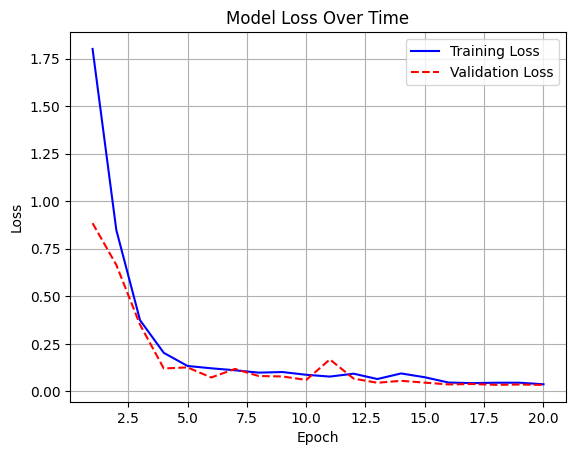

In [49]:
import torch.nn as nn

# Create dictionary to store metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Initialize model
model = ukko.core.DualAttentionModel(
    n_features=n_features,
    time_steps=sequence_length,
    d_model=128,
    n_heads=8,
    dropout=0.1
)

def train_sine_model(model, train_loader, val_loader, epochs=100, lr=0.001, device='cuda', verbose=True):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output, _, _ = model(x)
            #loss = criterion(output, y[:, :, 0])  # Compare with first time step of prediction
            loss = criterion(output, y)  # y is only one timepoint 5 or 4 steps ahead

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _, _ = model(x)
                #val_loss += criterion(output, y[:, :, 0]).item()
                val_loss += criterion(output, y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Log training progress:
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if verbose:
            print(f"Epoch {epoch+1:3.0f}/{epochs}, Train Loss: {train_loss:1.4f}, Val Loss: {val_loss:1.4f}")
            #print(f"Train Loss: {train_loss:1.4f}")
            #print(f"Val Loss: {val_loss:1.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_sine_model.pt')

# Train the model
train_sine_model(model, train_loader, val_loader, epochs=20)
history1 = history

# Visualize training
ukko.core.plot_training_curves(
    train_losses = history['train_loss'], 
    val_losses   = history['val_loss'],
    figsize=(15, 5),
)

## Visualize results

/tmp/ericfey1/26992887/ipykernel_2993945/3220880284.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_sine_model.pt'))


Loaded best model weights successfully!
Test Set Metrics:
Average MSE: 0.0298
Average MAE: 0.1287
RMSE: 0.1726


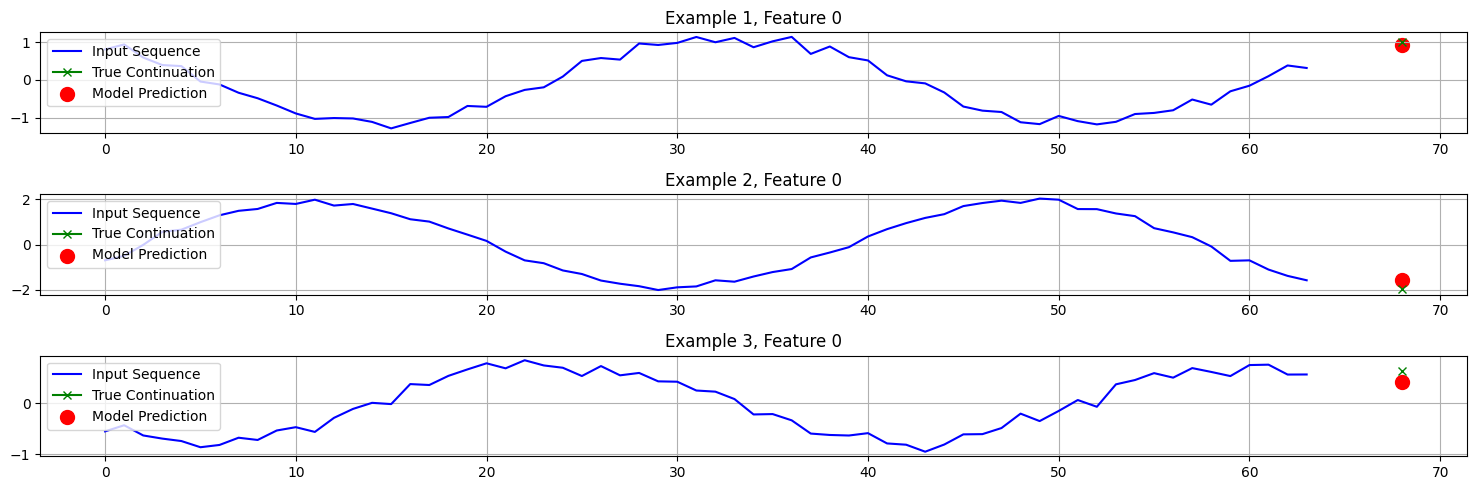

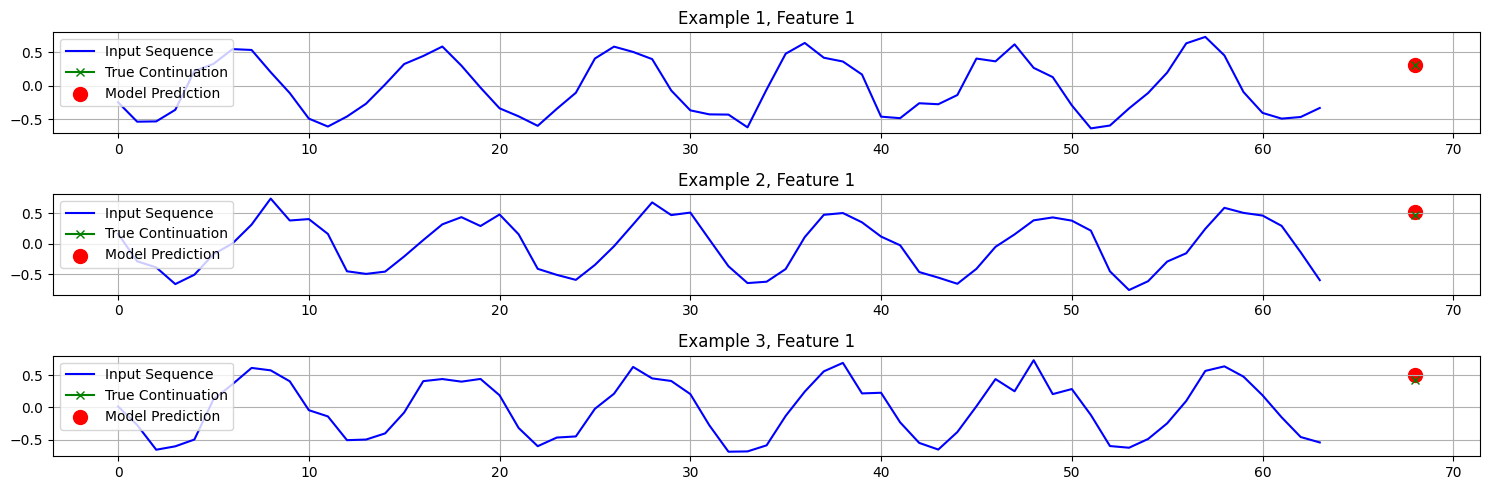

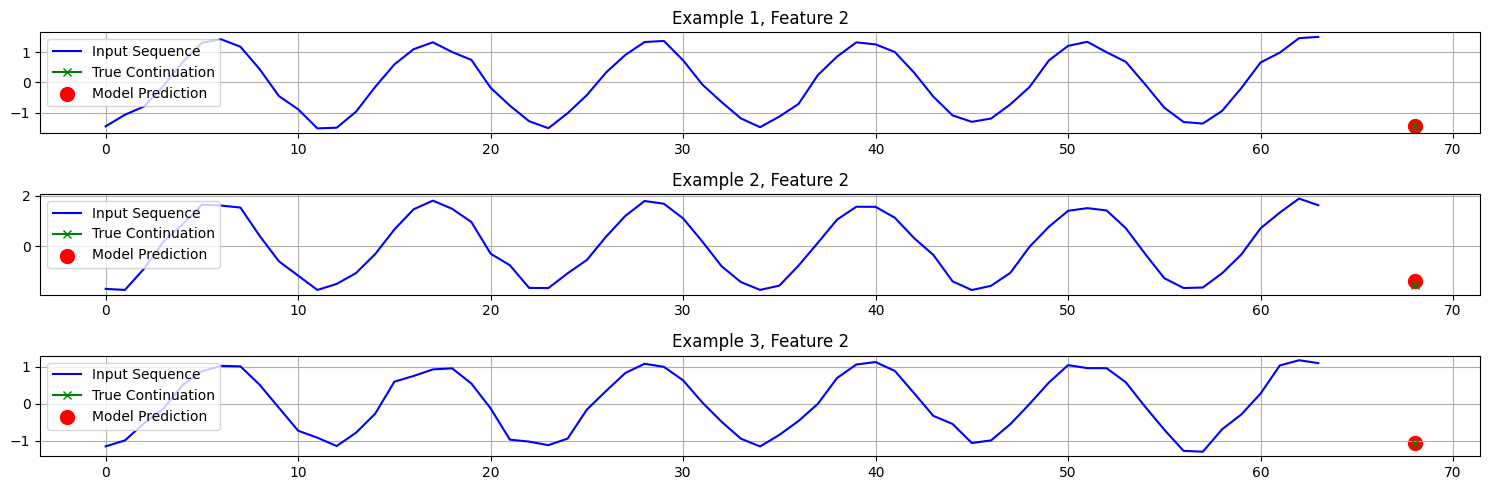

Data: (32, 5)
Predictions: (32, 5)


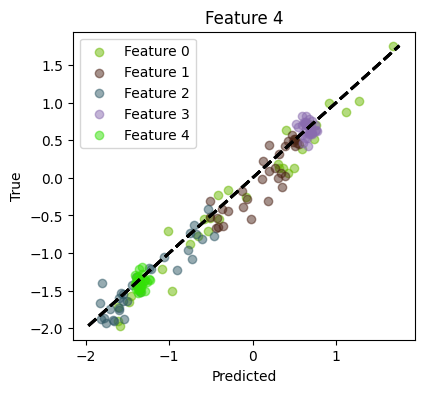

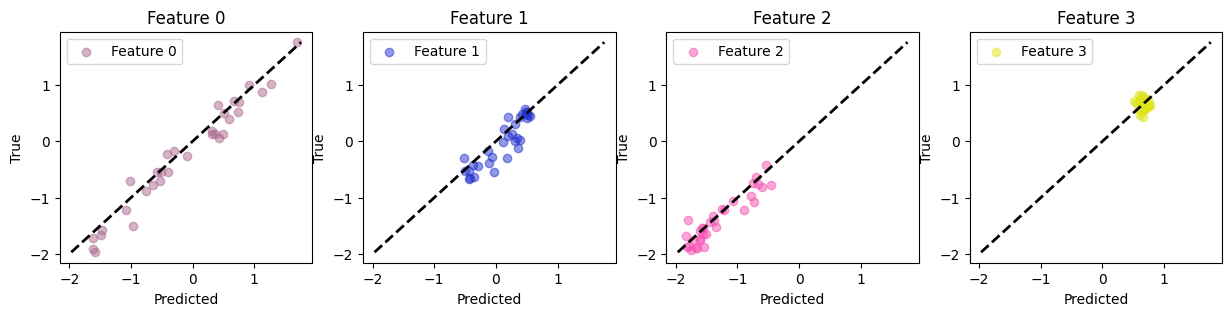

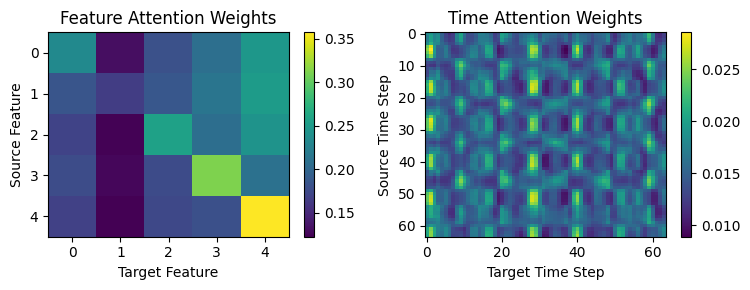

In [50]:
# Visualize results

import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

importlib.reload(ukko.data)
importlib.reload(ukko.core)
importlib.reload(ukko.test)

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    criterion = torch.nn.MSELoss()
    total_mse = 0
    total_mae = 0
    num_batches = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            predictions, _, _ = model(x)

            # Calculate MSE and MAE
            #mse = criterion(predictions, y[:, :, 0])
            #mae = torch.abs(predictions - y[:, :, 0]).mean()
            mse = criterion(predictions, y)
            mae = torch.abs(predictions - y).mean()

            total_mse += mse.item()
            total_mae += mae.item()
            num_batches += 1

    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    print(f"Test Set Metrics:")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")
    print(f"RMSE: {np.sqrt(avg_mse):.4f}")

    return avg_mse, avg_mae

def visualize_model_results(model):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if not model:
        print("No model present. Initialize model first. Be carfull to use the same model config.")
        return

    # Load best model weights
    try:
        model.load_state_dict(torch.load('best_sine_model.pt'))
        print("Loaded best model weights successfully!")
    except:
        print("No saved model found. Please train the model first.")
        return

    # Evaluate model
    mse, mae = evaluate_model(model, test_loader, device)

    # Visualize results
    ukko.core.visualize_predictions(model, test_loader, device)

    # Save a timestamp of when these results were generated
    timestamp = "2025-03-01 10:01:16"  # Using the provided timestamp
    user = "eric-fey-hus"

    # Save results to a file
    with open('model_results.txt', 'w') as f:
        f.write(f"Results generated on: {timestamp}\n")
        f.write(f"Generated by user: {user}\n")
        f.write(f"Model Performance Metrics:\n")
        f.write(f"MSE: {mse:.4f}\n")
        f.write(f"MAE: {mae:.4f}\n")
        f.write(f"RMSE: {np.sqrt(mse):.4f}\n")

#if __name__ == "__main__":
visualize_model_results(model)

# Test 2 Layer model

Observations:
- 2-layer model training is more variable, often takes longer to train

Epoch   1/40, Train Loss: 1.4884, Val Loss: 0.8933
Epoch   2/40, Train Loss: 0.9088, Val Loss: 0.8922
Epoch   3/40, Train Loss: 0.9026, Val Loss: 0.8873
Epoch   4/40, Train Loss: 0.9051, Val Loss: 0.8930
Epoch   5/40, Train Loss: 0.8492, Val Loss: 0.9002
Epoch   6/40, Train Loss: 0.5793, Val Loss: 0.3255
Epoch   7/40, Train Loss: 0.3681, Val Loss: 0.3236
Epoch   8/40, Train Loss: 0.3459, Val Loss: 0.4504
Epoch   9/40, Train Loss: 0.3351, Val Loss: 0.2437
Epoch  10/40, Train Loss: 0.2819, Val Loss: 0.2007
Epoch  11/40, Train Loss: 0.2041, Val Loss: 0.1194
Epoch  12/40, Train Loss: 0.1631, Val Loss: 0.1400
Epoch  13/40, Train Loss: 0.1279, Val Loss: 0.1699
Epoch  14/40, Train Loss: 0.1276, Val Loss: 0.0965
Epoch  15/40, Train Loss: 0.1047, Val Loss: 0.0861
Epoch  16/40, Train Loss: 0.1038, Val Loss: 0.1038
Epoch  17/40, Train Loss: 0.0880, Val Loss: 0.1046
Epoch  18/40, Train Loss: 0.0799, Val Loss: 0.0404
Epoch  19/40, Train Loss: 0.0784, Val Loss: 0.0746
Epoch  20/40, Train Loss: 0.087

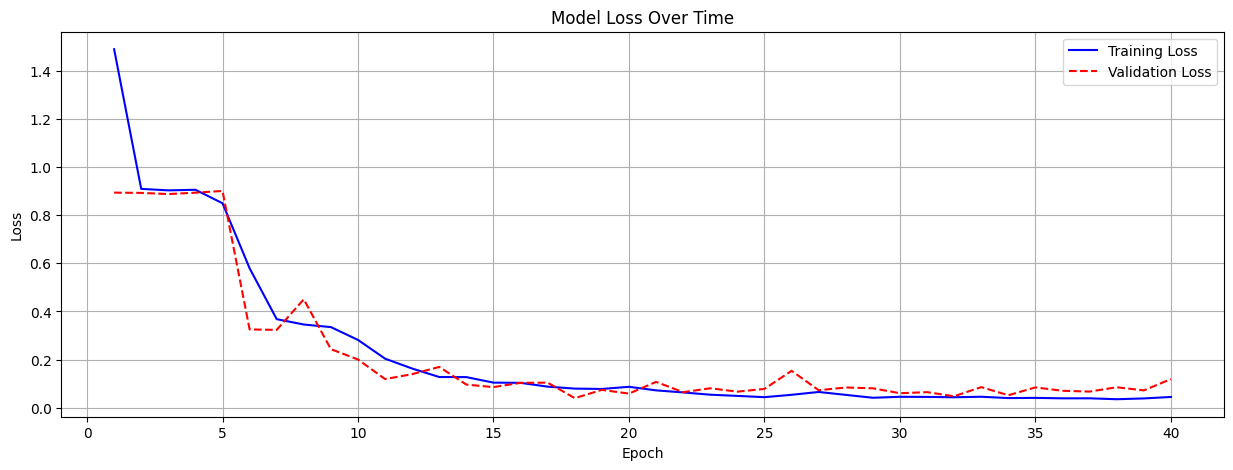

In [54]:
importlib.reload(ukko.core)

# Create dictionary to store metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Initialize model
model2 = ukko.core.DualAttentionModel(
    n_features=n_features,
    time_steps=sequence_length,
    d_model=64,
    n_heads=8,
    dropout=0.2,
    n_modules=2
)

# Train the model
train_sine_model(model2, train_loader, val_loader, epochs=40)
history2 = history

# Visualize training
plt.figure(figsize=(15, 5))
ukko.core.plot_training_curves(
    train_losses = history['train_loss'], 
    val_losses   = history['val_loss'],
    figsize=(15, 5),
)

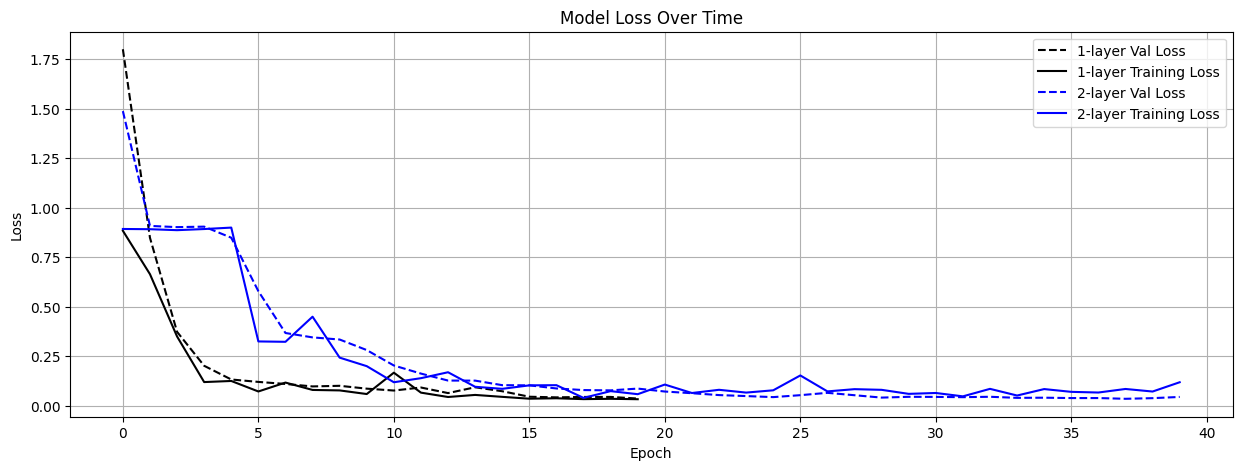

In [55]:
importlib.reload(ukko.core)

# Visualize training
plt.figure(figsize=(15, 5))

plt.plot(history1['train_loss'], 'k--', label='1-layer Val Loss')
plt.plot(history1['val_loss'], 'k-', label='1-layer Training Loss')
plt.plot(history2['train_loss'], 'b--', label='2-layer Val Loss')
plt.plot(history2['val_loss'], 'b-', label='2-layer Training Loss')

plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ericfey1/26992887/ipykernel_2993945/3220880284.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_sine_model.pt'))


Loaded best model weights successfully!
Test Set Metrics:
Average MSE: 0.0381
Average MAE: 0.1470
RMSE: 0.1951


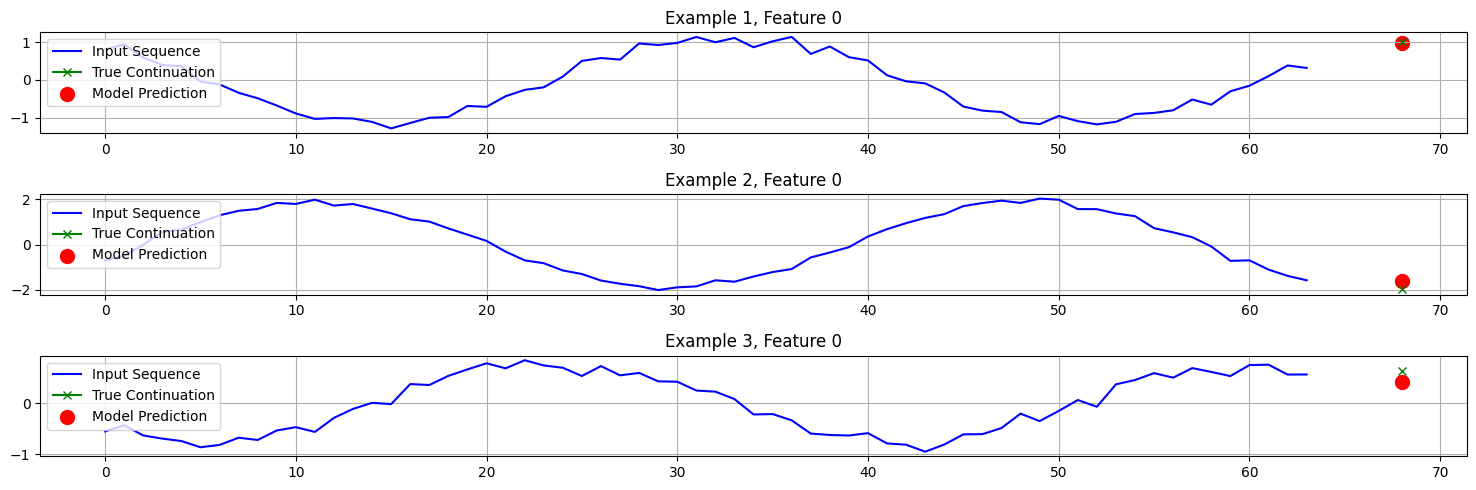

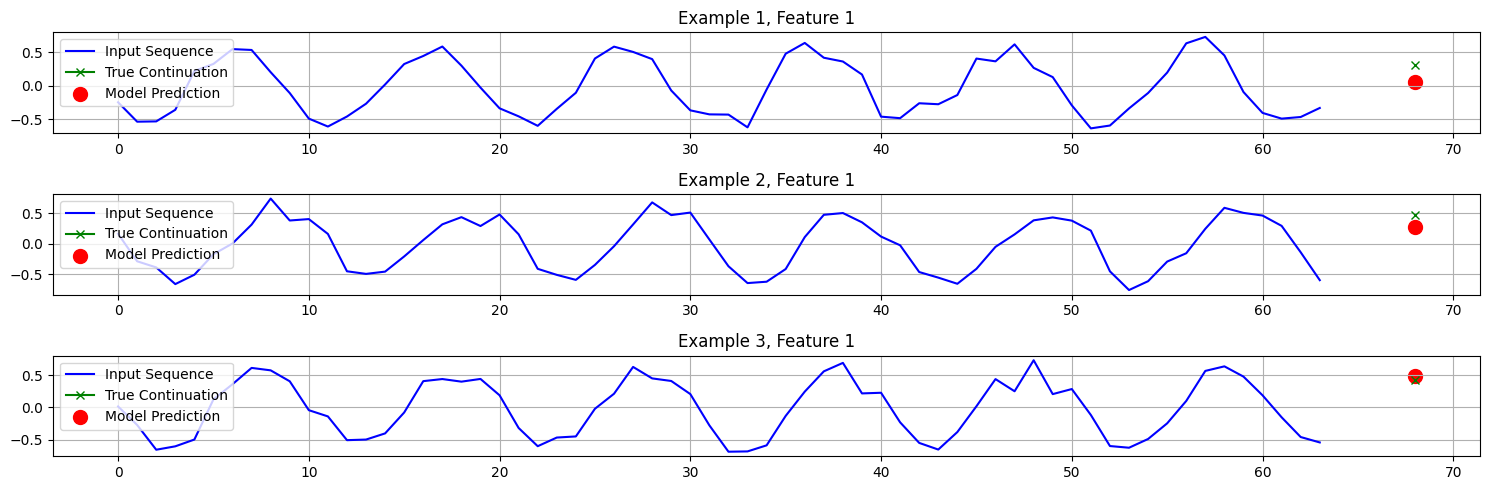

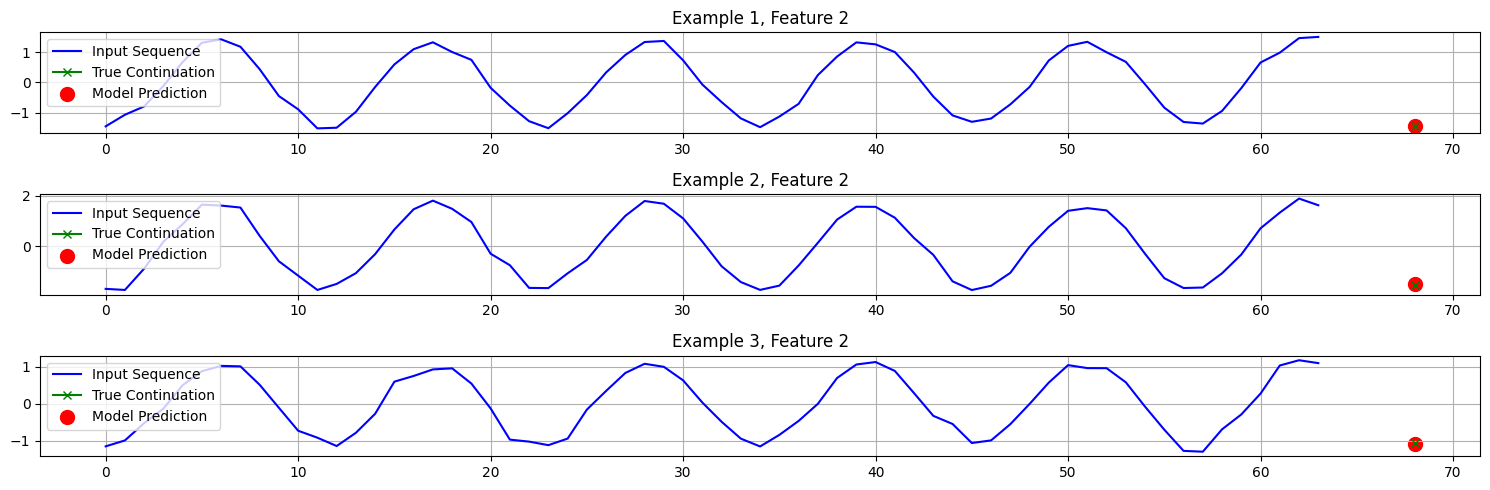

Data: (32, 5)
Predictions: (32, 5)


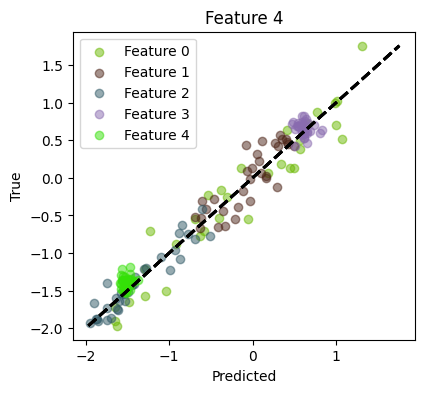

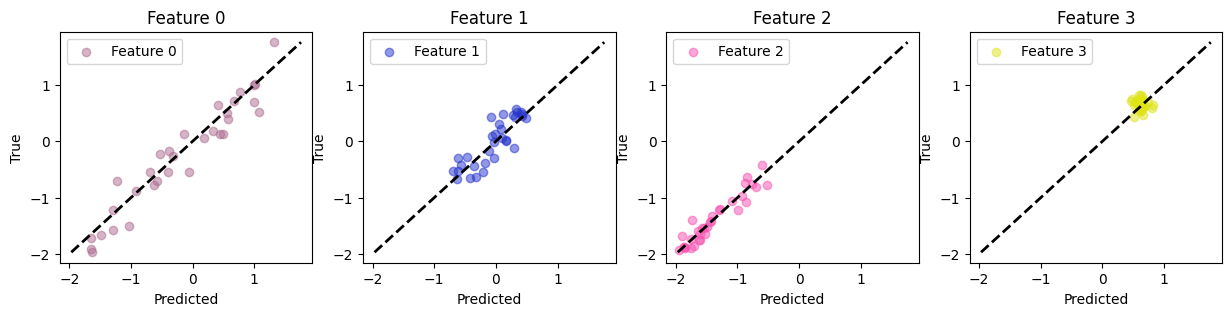

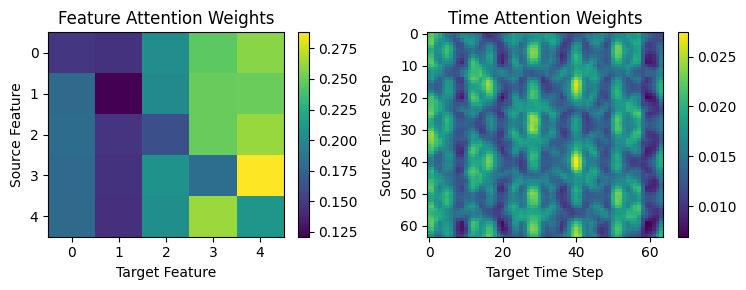

In [56]:
visualize_model_results(model2)